## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo IV - Estratégias de Treinamento e Transferência de Aprendizado</span>


### <span style="color:darkred">Avaliação</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

As respostas devem ser dadas no Moodle, use esse notebook apenas para gerar o código necessário para obter as respostas

---


### Questão 1)

Qual a relação entre o modelo chamado de "memorizador" e as redes neurais profundas?

(a) Redes neurais com alta capacidade podem memorizar todos os exemplos de treinamento, tornando-as hábeis para generalizar para dados futuros.<br>
<b>(b) Redes neurais com alta capacidade podem memorizar todos os exemplos de treinamento, falhando em predizer corretamente exemplos não vistos.<br></b>
(c) Redes neurais com alta capacidade são imunes a convergir para modelos memorizadores, pois obtiveram resultados do estado-da-arte em muitas aplicações.<br>
(d) Redes neurais com alta capacidade podem memorizar todos os exemplos de treinamento, e portanto possuem viés forte.<br>

---

### Questão 2)

O papel do uso conjunto dos métodos BatchNormalization e Regularização é o de:

(a) Pré-processamento dos dados antes da realização do treinamento<br>
(b) Gerar espaço de parâmetros esparsos, com alguns poucos parâmetros com valor alto e muitos com valores próximo a zero, melhorando a generalização<br>
<b>(c) Minimizar o problema do desaparecimento do gradiente, e ao mesmo tempo evitar que poucas unidades/neurônios se especializem demais<br></b>
(d) Obter robustez com relação à possíveis ataques e propiciar modelos menores com acurácia similar a modelos maiores<br>


---
### Questão 3)

São práticas viáveis para o uso de aprendizado profundo com pequenas bases de dados:

 (a) Carregar uma rede neural profunda popular de um pacote de software e treiná-la a partir de pesos aleatórios<br>
 <b>(b) Carregar uma rede neural profunda pré-treinada em grande base de dados, e utilizar a saída da última camada  da rede, ou seja as predições das classes, como característica para modelos de aprendizado externos que permitem uso com menores bases de dados<br></b>
 (c) Carregar uma rede neural profunda popular de um pacote de software e treiná-la a partir de pesos aleatórios utilizando Batch Normalization<br>
 (d) Carregar uma rede neural profunda pré-treinada em grande base de dados, inserindo uma nova camada de saída treinando apenas essa camada com a pequena base de dados<br>

---

### Questão 4)

Carregue a base de dados Fashion MNIST conforme código abaixo e crie um modelo de CNN com a seguinte arquitetura, capaz de obter classificação nessa base de dados de imagens. Considere que todas as camadas convolucionais tem zeropadding, e ativação relu, exceto quando mencionado contrário.

1. Pré-processamento para aumentação contendo:
  * RandomZoom(0.1),
  * RandomContrast(0.2)
1. Convolucional 2D com 64 filtros $3\times 3$.
2. Batch Normalization
3. SeparableConv2D com 64 filtros $3\times 3$.
4. MaxPooling2D $3\times 3$ e strides $2$
5. Batch Normalization
6. SeparableConv2D com 256 filtros $3\times 3$.
7. MaxPooling2D $3\times 3$ e strides $2$
8. GlobalAveragePooling
9. Dropout de 0.2
10. Densa com ativação softmax

Incialize as sementes do numpy com 1 e tensorflow com 2 e treine o modelo por 7 épocas com batch size 16, otimizador Adam e taxa de aprendizado 0.002.

Após o treinamento utilize a função predict para classificar imagens da posicao 10 a 14 no conjunto de testes ([10:15]). Quais as classes resultantes e quantas dessas estavam erradas?

(a) 2, 5, 5, 3, 3, sendo 2 erradas<br>
(b) 4, 5, 5, 3, 4, sendo 2 erradas<br>
<b>(c) 4, 5, 5, 3, 4 sendo 1 errada<br></b>
(d) 4, 5, 5, 3, 4, nenhuma errada<br>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

In [ ]:
print(tf.__version__)

In [6]:
#identificando número de linhas e colunas e número de classes
img_lin, img_col = train_images.shape[1], train_images.shape[2]
num_classes = len(np.unique(train_labels))

#verificando canais na base. Se tiver mais de 1 canal, armazena a quantidade de canais
if(len(train_images.shape) == 3):
    n_channels = 1
else:
    n_channels = train_images.shape[3]

#re-formatando imagens transformando-as em matrizes com canais
if keras.backend.image_data_format() == 'channels_first':
    train_images = train_images.reshape(train_images.shape[0], n_channels, img_lin, img_col)
    test_images = test_images.reshape(test_images.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    train_images = train_images.reshape(train_images.shape[0], img_lin, img_col, n_channels)
    test_images = test_images.reshape(test_images.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)
    
#pré-processamento com aumentação
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomContrast(0.2)
    ]
)

#rede CNN
def my_cnn(input_shape, num_classes, dropout_rate=0.2, batch_norm=False, augmentation=False):
    
    inputs = keras.Input(shape=input_shape)
    
    if(augmentation): #se tiver aumentação aplico na primeira camada da rede
        x = data_augmentation(inputs)
        x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(x)
    else: #caso contrário, passo a camada diretamente
        x = layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
        
    if(batch_norm): #se tiver batchNormalization
        x = layers.BatchNormalization()(x)
        
    x = layers.SeparableConv2D(64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    
    if(batch_norm): #se tiver batchNormalization
        x = layers.BatchNormalization()(x)
    
    x = layers.SeparableConv2D(256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)

In [7]:
#sementes
seed(1)
tf.random.set_seed(2)

#epochs e batch size
epochs = 7
batch_size = 16

CNN = my_cnn(input_shape, 10, dropout_rate=0.2, batch_norm=True, augmentation=True)

CNN.compile(optimizer=keras.optimizers.Adam(lr=0.002),
           loss='categorical_crossentropy',
           metrics=['accuracy'])

histCNN = CNN.fit(train_images, train_labels,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1)

Epoch 1/7
3750/3750 [==============================] - 413s 110ms/step - loss: 0.6342 - accuracy: 0.7672
Epoch 2/7
3750/3750 [==============================] - 410s 109ms/step - loss: 0.4163 - accuracy: 0.8504
Epoch 3/7
3750/3750 [==============================] - 406s 108ms/step - loss: 0.3679 - accuracy: 0.8670
Epoch 4/7
3750/3750 [==============================] - 375s 100ms/step - loss: 0.3419 - accuracy: 0.8763
Epoch 5/7
3750/3750 [==============================] - 409s 109ms/step - loss: 0.3206 - accuracy: 0.8839
Epoch 6/7
3750/3750 [==============================] - 411s 109ms/step - loss: 0.3088 - accuracy: 0.8875
Epoch 7/7
3750/3750 [==============================] - 404s 108ms/step - loss: 0.2950 - accuracy: 0.8921


Testes:
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Testes:
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


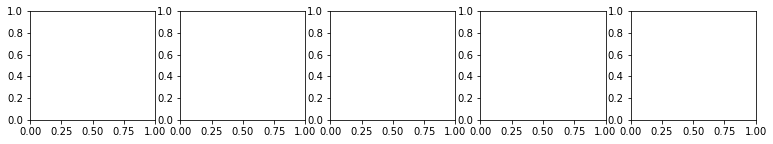

In [8]:
#dados para previsão
x_sub = test_images[10:15]
y_sub = test_labels[10:15]

fig, axes = plt.subplots(1, 5, figsize=(13,2))
ax = axes.ravel()

#print('Imagens de Teste:')

#for i in range(len(x_sub)):
#    ax[i].imshow(x_sub[i])
#    ax[i].set_title(y_sub[i])
#    ax[i].axis('off')
    
#fig.tight_layout()

print('Testes:')
print(np.round(y_sub))

print('Testes:')
print('[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]')
print(' [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]')
print(' [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]')
print(' [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]')
print(' [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]')

In [9]:
#predição do modelo
predictCNN = CNN.predict(x_sub,verbose=0)
print('Predições:')
print(np.round(predictCNN))


print('Predições:')
print('[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]')
print(' [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]')
print(' [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]')
print(' [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]')
print(' [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]')

Predições:
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Predições:
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


---

### Questão 5)

Carregue a base de dados MNIST do pacote Keras, e pre-processe conforme código abaixo.

Vamos utilizar o modelo treinado na questão anterior como forma de trasnferência de aprendizado. Se preciso reinicialize o modelo e treine-o novamente para garantir que apenas 7 épocas foram executadas. O modelo final deve ter acurácia de treinamento próxima a 0.89 (computada na base Fashion). 

Agora, assuma que esse modelo já treinado está armazenado numa variável `model`. Então proceda da seguinte forma:

1. Obtendo a saída da penúltima camada (referente ao Dropout):

`base_saida = model.layers[-2].output`

2. Criando uma nova camada de saída que recebe como entrada a anterior 

`saida_nova = keras.layers.Dense(10, activation='softmax')(base_saida)`

3. Criando um novo modelo tendo essa nova camada como saída 

`model2 = keras.models.Model(model.inputs, saida_nova)`

Você pode usar o summary para conferir o modelo montado.

Agora inicialize as sementes do numpy para 1 e tensorflow para 2, compile e treine o novo modelo com função de custo entropia cruzada categórica, otimizador Adam com taxa de aprendizado 0.002, 16 exemplos no mini-batch e 3 épocas.

Avalie a acurácia no conjunto de testes. Em qual intervalo está a acurácia resultante, considerando arredondamento para 2 casas decimais?

(a) [0.94,0.96]<br>
<b>(b) [0.98,1.00]<br></b>
(c) [0.87,0.90]<br>
(d) [0.92,0.93]<br>

In [ ]:
mnist = keras.datasets.mnist
(train_images2, train_labels2), (test_images2, test_labels2) = mnist.load_data()
train_images2 = train_images2 / 255.0
test_images2 = test_images2 / 255.0
train_labels2 = keras.utils.to_categorical(train_labels2, 10)
test_labels2 = keras.utils.to_categorical(test_labels2, 10)

In [ ]:
#obtendo saída da penultima camada
base_saida = CNN.layers[-2].output

#criando nova camada de saída que recebe a anterior
saida_nova = keras.layers.Dense(10, activation='softmax')(base_saida)

#criando novo modelo, tendo essa nova camada de saída
CNN2 = keras.models.Model(CNN.inputs, saida_nova)

In [ ]:
#sementes
seed(1)
tf.random.set_seed(2)

#epochs e batch size
epochs2 = 3
batch_size2 = 16

#CNN2 = my_cnn(input_shape, 10, dropout_rate=0.2, batch_norm=True, augmentation=True)

CNN2.compile(optimizer=keras.optimizers.Adam(lr=0.002),
           loss='categorical_crossentropy',
           metrics=['accuracy'])

histCNN2 = CNN2.fit(train_images2, train_labels2,
                 batch_size=batch_size2,
                 epochs=epochs2,
                 verbose=1)

scoreCNN2 = CNN2.evaluate(test_images2, test_labels2, verbose=0)
print("Perda = %.2f, Acurácia = %.2f (Epocas=%d)" % (scoreCNN2[0], scoreCNN2[1], epochs2))

In [ ]:
Epoch 1/3
3750/3750 [==============================] - 255s 68ms/step - loss: 0.1881 - accuracy: 0.9426
Epoch 2/3
3750/3750 [==============================] - 253s 67ms/step - loss: 0.0720 - accuracy: 0.9776
Epoch 3/3
3750/3750 [==============================] - 255s 68ms/step - loss: 0.0592 - accuracy: 0.9817
Perda = 0.04, Acurácia = 0.99 (Epocas=3)